<a href="https://colab.research.google.com/github/lolddong/data_analysis/blob/main/17_CNN_CatsAndDogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CNN-고양이,개 이미지 분류
- URL: https://www.kaggle.com/datasets/tongpython/cat-and-dog
- 구성: `cat.인덱스번호.jpg`와 `dog.인덱스번호.jpg` 형식으로 개 이미지 `12,500`개, 고양이 이미지 `12,500`개
- (Google Colab에서 수행)
## 1. 패키지 가져오기

In [3]:
import os
import helper
import zipfile

from PIL import Image
from pandas import DataFrame
from matplotlib import pyplot as plt
import seaborn as sb
import numpy as np
import datetime as dt

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 2. 데이터셋 준비하기
### 1) 구글 드라이브 연결
- Colab의 파일 트리에 `drive`라는 항목이 나타나면 됨

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### 2) 이미지 파일 압축 해제
- 압축 파일을 구글 드라이브에 `업로드 한 상태`에서 수행

In [13]:
# 압축파일의 경로
file_path = '/content/drive/MyDrive/Colab Notebooks/CatsAndDogs.zip'

# 압축을 해제할 경로
extract_dir = os.path.join(os.getcwd(), "data")

# 해당 폴더가 없다면 폴더를 생성
if not os.path.exists(extract_dir):
    os.mkdir(extract_dir)

# 파일의 압축 해제
zip_ref = zipfile.ZipFile(file_path, 'r')
zip_ref.extractall(extract_dir)
zip_ref.close()

- 압축 파일을 구글 드라이브에 `업로드 하지 않은 상태`에서 수행

### 3) 파일 경로 확인
- 훈련용, 검증용 데이터셋의 경로

In [16]:
# 훈련용 데이터셋의 경로
train_cats_dir = os.path.join(extract_dir, 'training_set/training_set/cats')
train_dogs_dir = os.path.join(extract_dir, 'training_set/training_set/dogs')
print(train_cats_dir)
print(train_dogs_dir)

# 검증용 데이터셋의 경로
test_cats_dir = os.path.join(extract_dir, 'test_set/test_set/cats')
test_dogs_dir = os.path.join(extract_dir, 'test_set/test_set/dogs')
print(test_cats_dir)
print(test_dogs_dir)

/content/data/training_set/training_set/cats
/content/data/training_set/training_set/dogs
/content/data/test_set/test_set/cats
/content/data/test_set/test_set/dogs


### 4) 각 폴더별로 이미지 파일의 수 확인

In [17]:
print('훈련용 고양이 이미지: %d개' % len(os.listdir(train_cats_dir)))
print('훈련용 개 이미지: %d개' % len(os.listdir(train_dogs_dir)))
print('검증용 고양이 이미지: %d개' % len(os.listdir(test_cats_dir)))
print('검증용 개 이미지: %d개' % len(os.listdir(test_dogs_dir)))

훈련용 고양이 이미지: 4001개
훈련용 개 이미지: 4006개
검증용 고양이 이미지: 1012개
검증용 개 이미지: 1013개


## 3. 데이터 전처리
- 결측치 이상치 등이 없는 데이터셋이므로 생략

## 4. 탐색적 데이터 분석
### 1) 임의의 이미지 확인

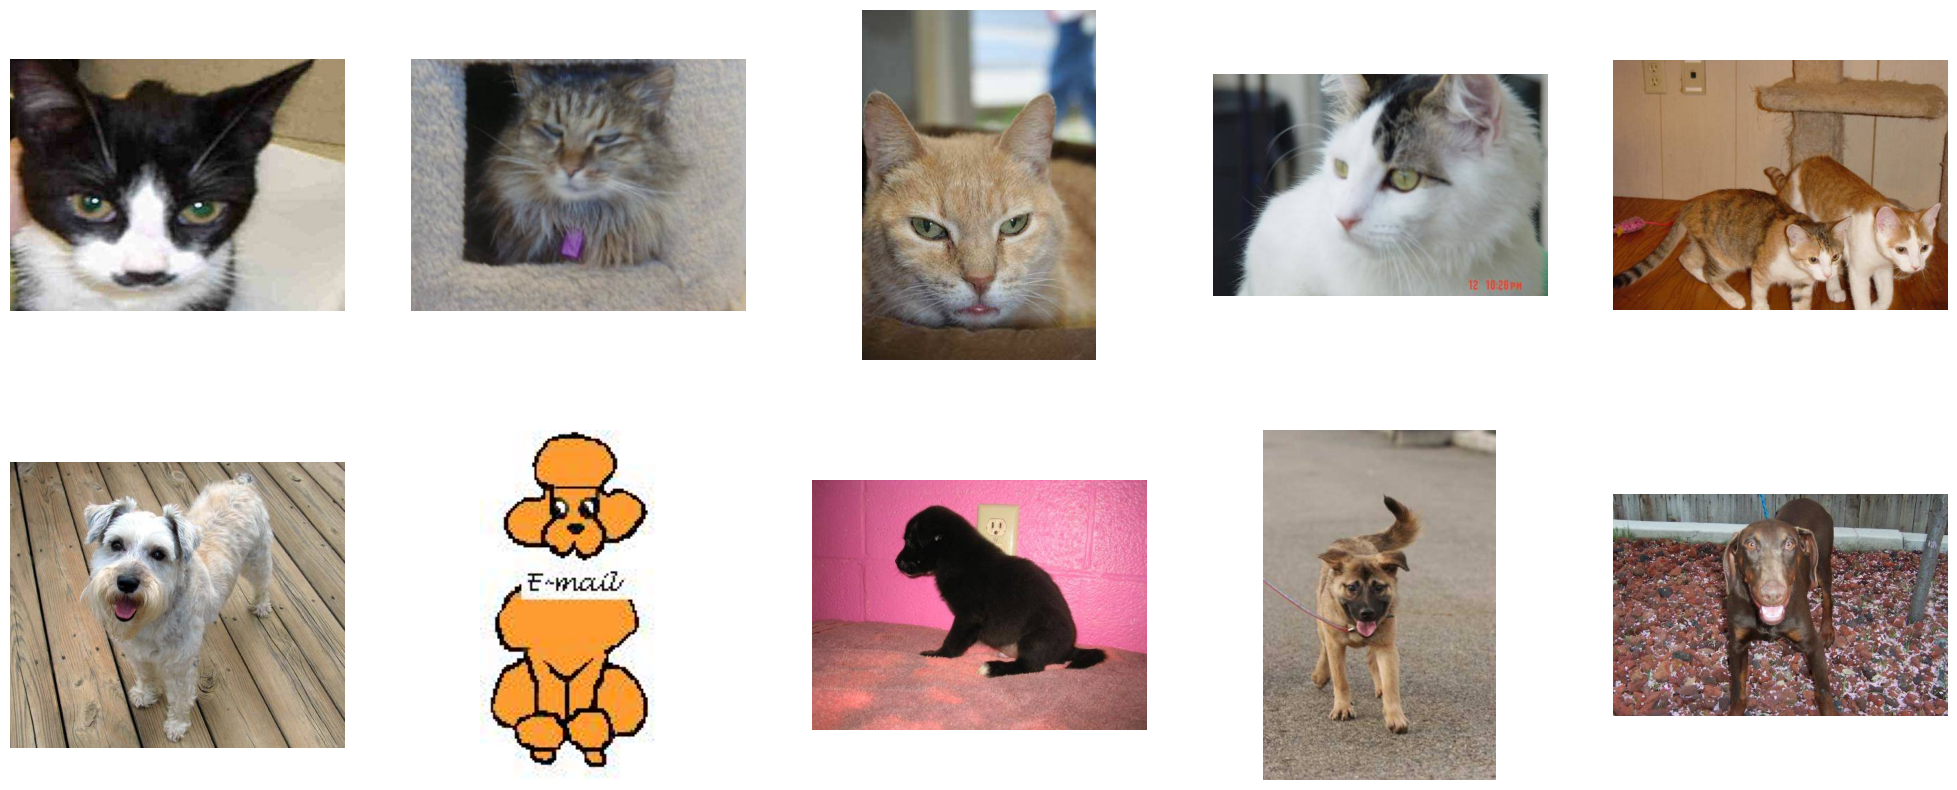

In [21]:
fig, ax = plt.subplots(2, 5, figsize = (25, 10), dpi = 100)
for i in range(0, len(ax)):
  dir = train_cats_dir if i == 0 else train_dogs_dir
  files = os.listdir(dir)

  for j in range(0, len(ax[i])):
    file_path = os.path.join(dir, files[j])
    sample = Image.open(file_path)
    ax[i][j].imshow(sample)
    ax[i][j].axis('off')
plt.show()
plt.close()

> 출력결과를 통해 이미지의 해상도가 모두 다르다는 것을 알 수 있다. 이 경우 입력 데이터의 shape가 모두 상이하기 때문에 학습이 불가능하다.
>
> 그러므로 모든 이미지를 균일하게 리사이즈 해야한다.
>
> 또한, 학습/검증용 이미지가 매우 부족하기 때문에 이미지를 반전, 회전, 색상 변환 등의 방법을 적용하여 학습 데이터를 증강시켜야 한다

### 2) 이미지 데이터 전처리
#### 이미지 증강
- 훈련 및 검증용 이미지가 저장되어 있는 폴더는 구분하고자 하는 종속변수의 수 만큼 하위 폴더를 갖는다.
> 개와 고양이로 이진 분류를 해야 하는 경우 2개의 하위 폴더가 필요하다는 의미 (cats, dogs)
- `ImageDataGereator`는 훈련용 이미지가 저장되어 있는 폴더, 검증용 이미지가 저장되어있는 폴더까지만 전달한다
- `ImgaeDataGenerator`가 하위 폴더를 식별하여 그 안의 cats와 dogs 폴더 안의 항목들을 읽어들인다

In [22]:
extract_dir

'/content/data'

In [24]:
training_dir = os.path.join(extract_dir, 'training_set/training_set')
test_dir = os.path.join(extract_dir, 'test_set/test_set')
train_datagen = ImageDataGenerator(rescale=1.0/255)
test_datagen = ImageDataGenerator(rescale=1.0/255)

train_set = train_datagen.flow_from_directory(training_dir,
                                              classes=['cats', 'dogs'],
                                              batch_size = 20,          # 이미지를 증강시킬 배수
                                              class_mode = 'binary',    # 이진분류용임을 명시
                                              target_size = (150, 150)) # 변환될 이미지 해상도

test_set = test_datagen.flow_from_directory(test_dir,
                                            classes=['cats', 'dogs'],
                                            batch_size = 20,
                                            class_mode = 'binary',
                                            target_size = (150, 150))


Found 8005 images belonging to 2 classes.
Found 2023 images belonging to 2 classes.


## 5. 모델 개발
### 1) 모델 정의

In [25]:
my_model = Sequential()
my_model.add(Conv2D(filters=16,           # 필터/커널 개수 -> 클수록 모델이 더 정확해짐
                    kernel_size=(5, 5),   # 필터/커널 크기 => 작아질수록 모델이 더 정확해짐, 그러나 시간 더 소요
                    strides=(1, 1),       # 필터의 이동 간격
                    padding='same',       # same = input과 output이 같도록 패딩, valid = 패딩이 없음
                    activation='relu',
                    input_shape=(150, 150, 3))) # 첫 레이어에 input으로 들어오는 크기
my_model.add(BatchNormalization())        # 배치정규화
my_model.add(MaxPool2D(pool_size=(2, 2),  # 축소시킬 필터의 크기(비율)
                       strides = (2,2)))  # 필터의 이동 간격 (default = pool_size)
my_model.add(Dropout(0.25))               # 랜덤으로 25%의 뉴런을 쉬게함

my_model.add(Conv2D(filters = 32,
                    kernel_size = (3, 3),
                    strides=(1, 1),
                    padding='same',
                    activation = 'relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D(pool_size=(2, 2),
                       strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Conv2D(filters = 64,
                    kernel_size = (2, 2),
                    strides=(1, 1),
                    padding='same',
                    activation = 'relu'))
my_model.add(BatchNormalization())
my_model.add(MaxPool2D(pool_size=(2, 2),
                       strides=(2,2)))
my_model.add(Dropout(0.25))

my_model.add(Flatten())
my_model.add(Dense(512, activation='relu'))
my_model.add(Dense(1, activation='sigmoid'))

my_model.compile(optimizer = 'adam',
                 loss = 'binary_crossentropy',
                 metrics=['acc'])

my_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 150, 16)      1216      
                                                                 
 batch_normalization (Batch  (None, 150, 150, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 75, 75, 16)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 75, 75, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 75, 32)        4640      
                                                                 
 batch_normalization_1 (Bat  (None, 75, 75, 32)        1

### 2) 학습하기

In [28]:
start = dt.datetime.now()

result = my_model.fit(train_set,
                      epochs=500,
                      validation_data=test_set,
                      callbacks=[EarlyStopping(monitor='val_loss',
                                               patience = 5,
                                               verbose=1),
                                 ReduceLROnPlateau(monitor='val_loss',
                                                   patience=3,
                                                   factor=0.5,
                                                   min_lr=0.0001,
                                                   verbose=1)])

end = dt.datetime.now()

delta = end-start
'총 학습 소요시간: %d(초)' % delta.seconds

Epoch 1/500
401/401 [==============================] - 31s 46ms/step - loss: 1.0135 - acc: 0.6352 - val_loss: 4.3727 - val_acc: 0.5754 - lr: 0.0010
Epoch 2/500
401/401 [==============================] - 21s 51ms/step - loss: 0.5416 - acc: 0.7264 - val_loss: 0.5828 - val_acc: 0.6906 - lr: 0.0010
Epoch 3/500
401/401 [==============================] - 18s 45ms/step - loss: 0.4948 - acc: 0.7594 - val_loss: 3.2608 - val_acc: 0.6154 - lr: 0.0010
Epoch 4/500
401/401 [==============================] - 19s 47ms/step - loss: 0.4538 - acc: 0.7879 - val_loss: 0.6236 - val_acc: 0.6856 - lr: 0.0010
Epoch 5/500
400/401 [============================>.] - ETA: 0s - loss: 0.3928 - acc: 0.8215
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
401/401 [==============================] - 19s 47ms/step - loss: 0.3924 - acc: 0.8217 - val_loss: 0.6426 - val_acc: 0.7093 - lr: 0.0010
Epoch 6/500
401/401 [==============================] - 18s 44ms/step - loss: 0.2787 - acc: 0.8796 - val_

'총 학습 소요시간: 148(초)'

## 6. 학습 결과 평가

In [29]:
# 학습 결과
result_df = DataFrame(result.history)
result_df['epochs'] = result_df.index+1
result_df.set_index('epochs', inplace=True)
result_df

loss       acc  val_loss   val_acc      lr
epochs                                                
1       1.013536  0.635228  4.372678  0.575383  0.0010
2       0.541637  0.726421  0.582829  0.690559  0.0010
3       0.494775  0.759400  3.260768  0.615423  0.0010
4       0.453769  0.787883  0.623609  0.685615  0.0010
5       0.392398  0.821736  0.642559  0.709343  0.0010
6       0.278702  0.879575  0.706815  0.757291  0.0005
7       0.213658  0.909307  0.800882  0.758280  0.0005

In [30]:
# Colab 그래프 한글글꼴 설정
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf

from matplotlib import font_manager as fm
import matplotlib.pyplot as plt
fe = fm.FontEntry(fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf',
                  name='NanumGothic')
fm.fontManager.ttflist.insert(0, fe)
plt.rcParams.update({'font.size':18, 'font.family':'NanumGothic'})

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following NEW packages will be installed:
  fonts-nanum
0 upgraded, 1 newly installed, 0 to remove and 18 not upgraded.
Need to get 10.3 MB of archives.
After this operation, 34.1 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 fonts-nanum all 20200506-1 [10.3 MB]
Fetched 10.3 MB in 0s (22.7 MB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package fonts-nanum.
(Reading database ... 120895 files and direc

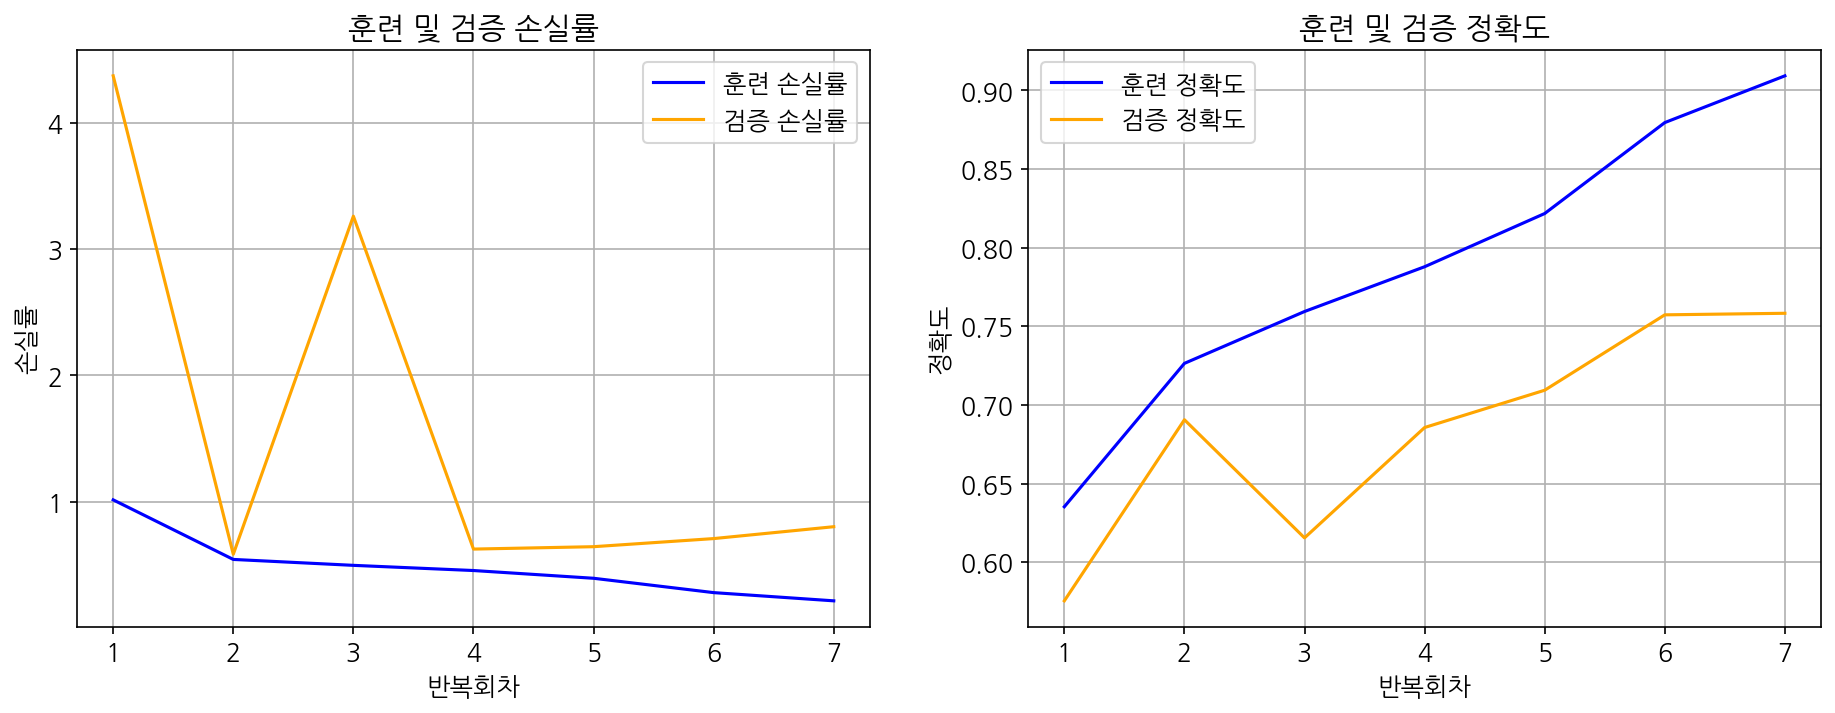

In [33]:
# 그래프 기본설정
plt.rcParams['font.size'] = 12
plt.rcParams['axes.unicode_minus'] = False

# 그래프를 그리기 위한 객체 생성
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5), dpi=150)

# 1) 훈련 및 검증 손실 그리기
sb.lineplot(x=result_df.index,
            y='loss',
            data=result_df,
            color='blue',
            label='훈련 손실률',
            ax=ax1)
sb.lineplot(x=result_df.index,
            y='val_loss',
            data=result_df,
            color='orange',
            label='검증 손실률',
            ax = ax1)
ax1.set_title('훈련 및 검증 손실률')
ax1.set_xlabel('반복회차')
ax1.set_ylabel('손실률')
ax1.grid()
ax1.legend()

# 2) 훈련 및 검증 절대오차 그리기
sb.lineplot(x=result_df.index,
            y='acc',
            data=result_df,
            color='blue',
            label='훈련 정확도',
            ax=ax2)
sb.lineplot(x=result_df.index,
            y='val_acc',
            data=result_df,
            color='orange',
            label='검증 정확도',
            ax=ax2)
ax2.set_title('훈련 및 검증 정확도')
ax2.set_xlabel('반복회차')
ax2.set_ylabel('정확도')
ax2.grid()
ax2.legend()

plt.show()
plt.close()

In [39]:
evaluate1 = my_model.evaluate(train_set)
print('최종 훈련 손실률: %f, 최종 훈련 정확도: %f' % (evaluate1[0], evaluate1[1]))
evaluate2 = my_model.evaluate(test_set)
print('최종 검증 손실률: %f, 최종 검증 정확도: %f' % (evaluate2[0], evaluate2[1]))

401/401 [==============================] - 14s 35ms/step - loss: 0.2293 - acc: 0.9076
최종 훈련 손실률: 0.229250, 최종 훈련 정확도: 0.907558
102/102 [==============================] - 3s 31ms/step - loss: 0.8009 - acc: 0.7583
최종 검증 손실률: 0.800882, 최종 검증 정확도: 0.758280


## 7. 학습 결과 적용
### 1) 훈련 데이터에 대한 예측 결과 산정

In [44]:
pred = my_model.predict(train_set)
data_count, case_count = pred.shape
print('%d개의 훈련 데이터가 %d개의 경우의 수를 갖는다' % (data_count, case_count))
pred

401/401 [==============================] - 13s 33ms/step
8005개의 훈련 데이터가 1개의 경우의 수를 갖는다


array([[9.9547946e-01],
       [9.1788501e-01],
       [9.9999213e-01],
       ...,
       [2.8579449e-02],
       [9.9997377e-01],
       [1.3188015e-05]], dtype=float32)

In [45]:
pred_result = np.round(pred)
pred_result = pred_result.flatten()
pred_result


array([1., 1., 1., ..., 0., 1., 0.], dtype=float32)

### 2) 데이터 비교

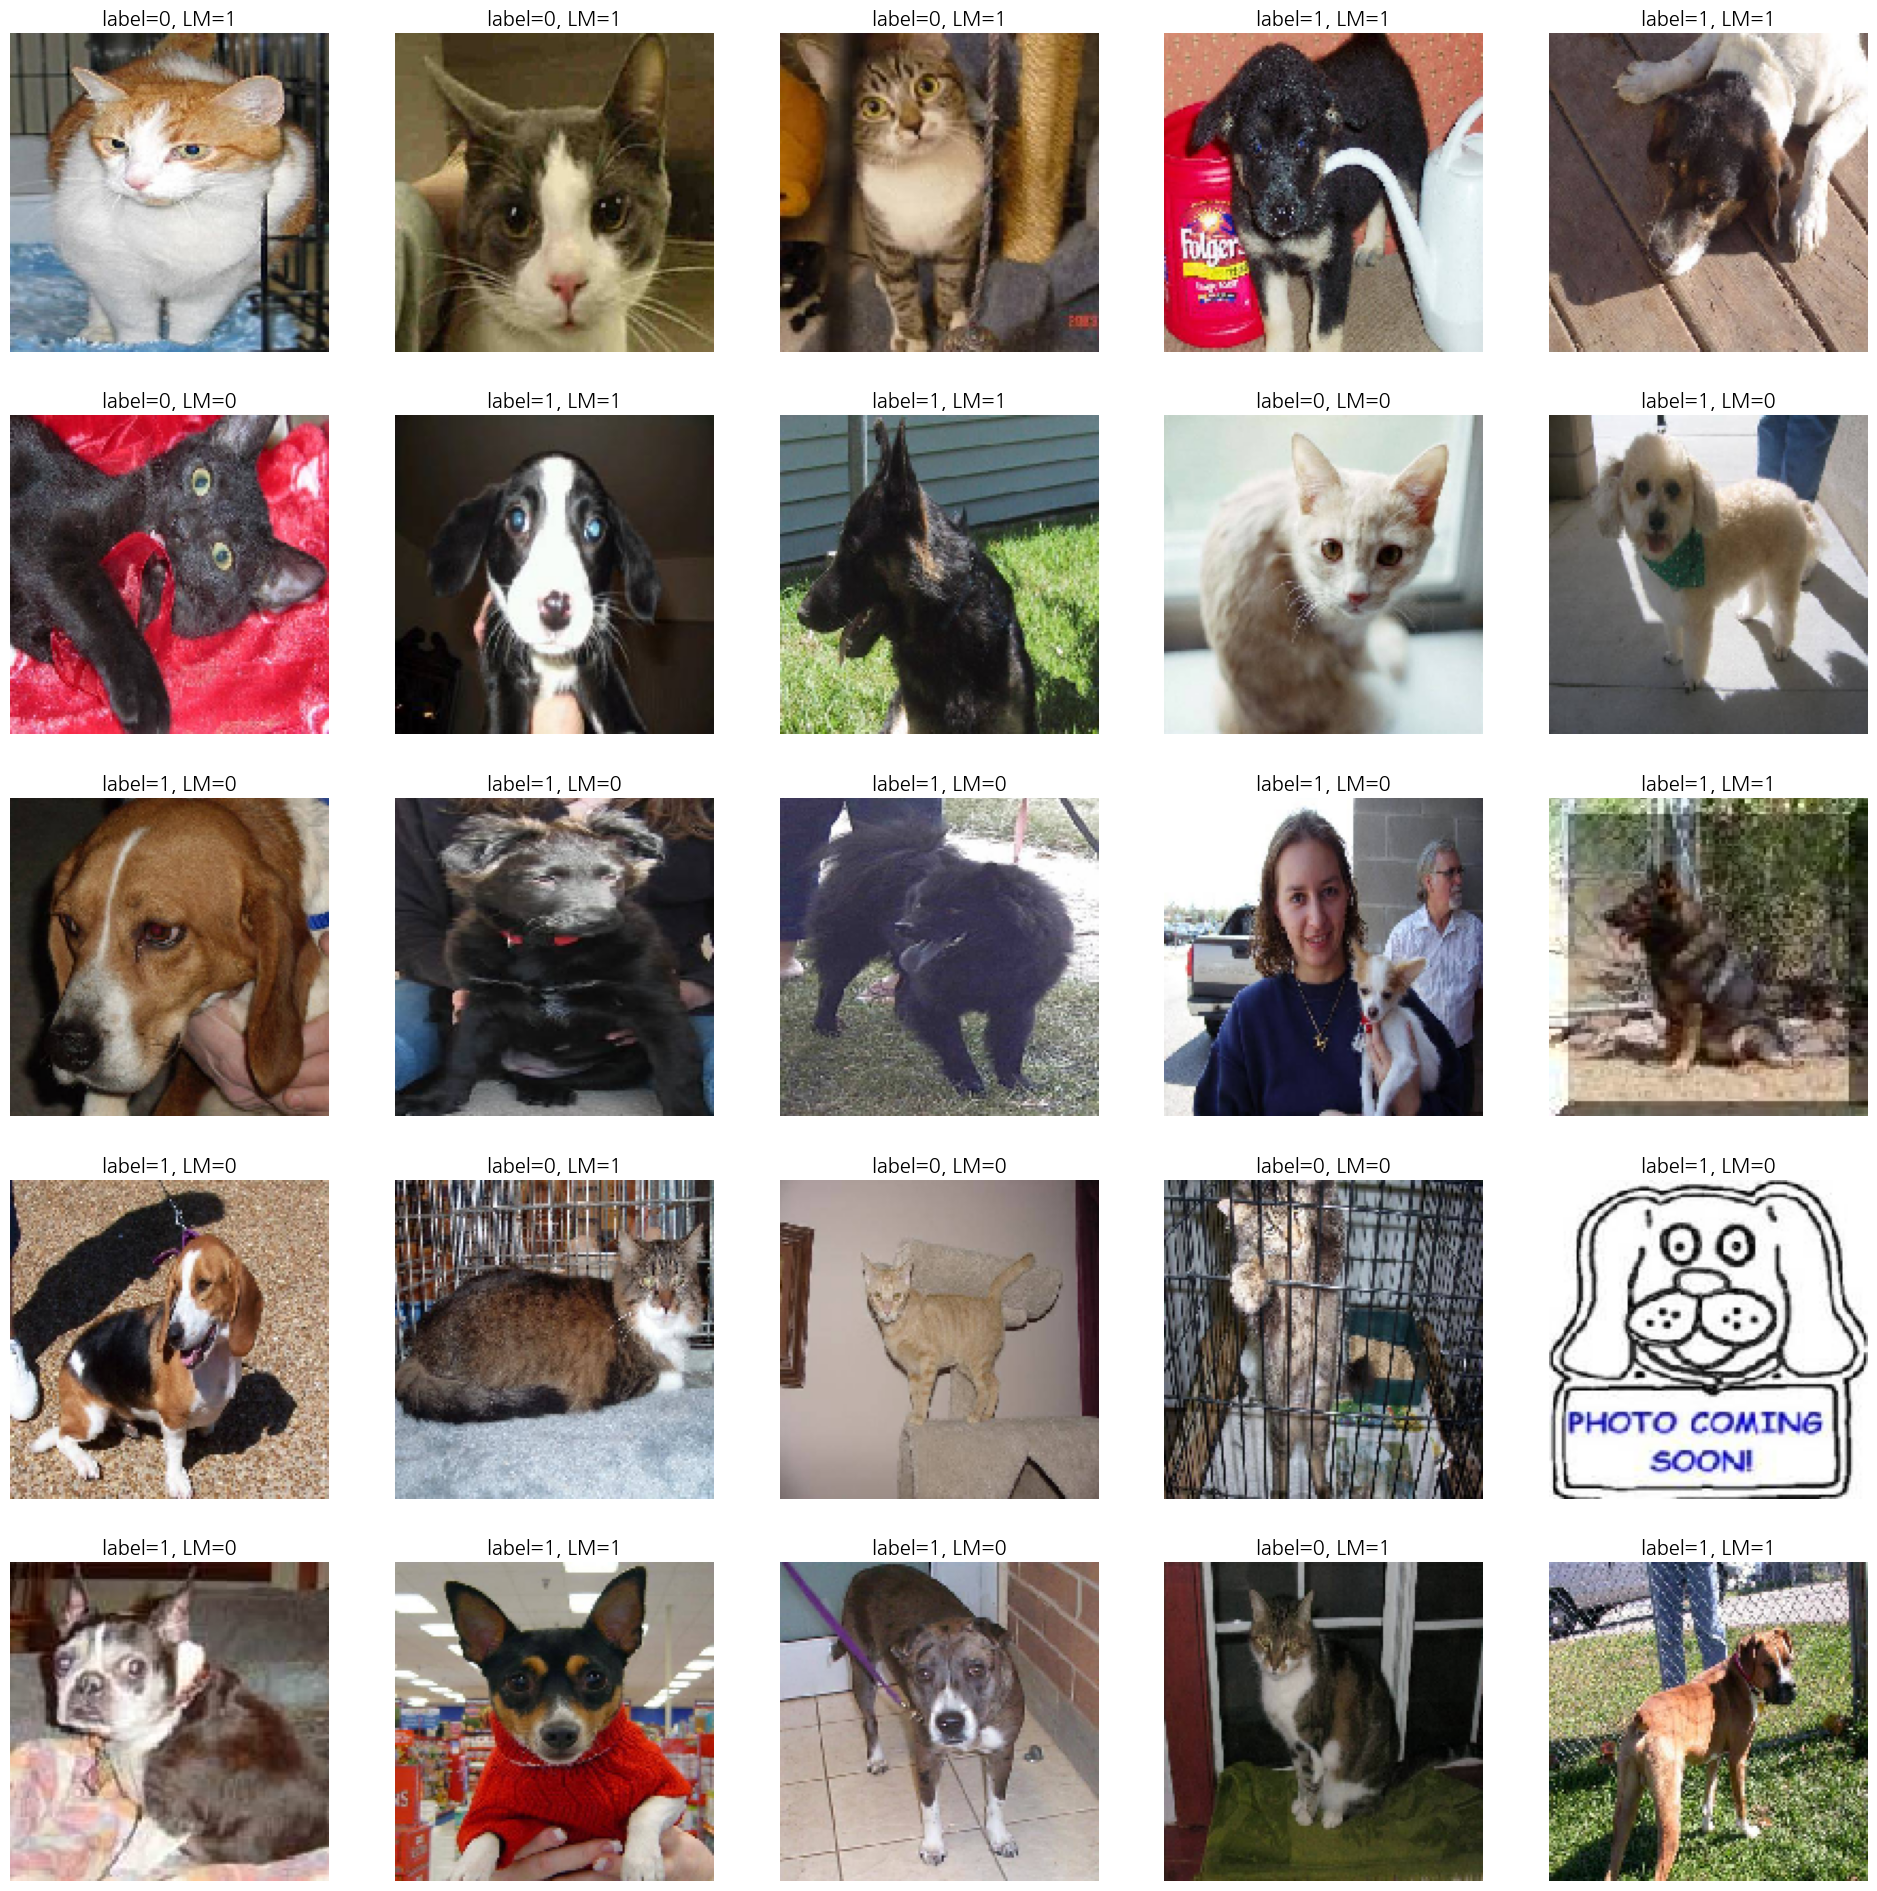

In [46]:
row = 5
col = 5
fig, ax = plt.subplots(row,
                       col,
                       figsize = ((col+1)*4, (row+1)*4),
                       dpi=100)

size = row*col
length = len(train_set)

for i in range(0, size):
  img, label = train_set.next()
  ax[i//col][i%col].imshow(img[0])
  ax[i//col][i%col].set_title('label=%d, LM=%d' % (label[0],
                                                   pred_result[i]))
  ax[i//col][i%col].axis('off')

plt.show()
plt.close()